# Sanity Check (Cascading Randomization) for Saliency Maps: ResNet-18 ImageNet Example

In [1]:
from torchvision import datasets, transforms, models
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, DeepLift
from src import util
import PIL
from ntpath import basename
import os

resnet = models.resnet18(pretrained=True)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
def show_image(file_path, resize=True, sztple=(299, 299)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img

def preprocess_image(file_path):
    img = PIL.Image.open(file_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = preprocess(img)
    return img.unsqueeze(0)

def get_image_and_label(file_path, image_net_cls, normalize=False):
    img = PIL.Image.open(file_path).convert('RGB')
    img_name = basename(file_path)
    cls_name = img_name[img_name.find('_') + 1:img_name.find('.')].replace('_', ' ')
    label = image_net_cls[cls_name]
    if not normalize:
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])
        img = preprocess(img)
        return img.unsqueeze(0), label
    else:
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img = preprocess(img)
        return img, label
    
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, dir_path):
        super(MyDataset).__init__()
        self.dir_path = dir_path
        with open("imagenet_classes.txt", "r") as f:
            self.image_net_cls = {s.strip(): idx for idx, s in enumerate(f.readlines())}
        
    def __iter__(self):
        iter([get_image_and_label(x) for x in os.listdir(self.dir_path)])
    
    def __getitem__(self, idx):
        file_name = os.listdir(self.dir_path)[idx]
        return get_image_and_label(os.path.join(self.dir_path, file_name), self.image_net_cls, normalize=True)
        
    def __len__(self):
        return len(os.listdir(self.dir_path))
        

def show_image(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)

# img, label = get_image_and_label('imagenet-sample-images/n01440764_tench.JPEG')
# plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())
# with open('imagenet-sample-images/n01440764_tench.JPEG', '')

In [3]:
my_set = MyDataset('imagenet-sample-images')
dataset_subset = torch.utils.data.Subset(my_set, np.random.choice(len(my_set), 2, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

# img, label = get_image_and_label('imagenet-sample-images/n01440764_tench.JPEG', image_net_cls, normalize=True)
# with torch.no_grad():
#     output = resnet(img)
    
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# # Read the categories
# with open("imagenet_classes.txt", "r") as f:
#     categories = [s.strip() for s in f.readlines()]
# # Show top categories per image
# top5_prob, top5_catid = torch.topk(probabilities, 5)
# for i in range(top5_prob.size(0)):
#     print(categories[top5_catid[i]], top5_prob[i].item())

In [4]:
# define module paths for cascading randomization
module_paths = [
    ['fc'],
    ['layer4', '1'], ['layer4', '0'],
    ['layer3', '1'], ['layer3', '0'],
    ['layer2', '1'], ['layer2', '0'],
    ['layer1', '1'], ['layer1', '0'],
    ['bn1'], ['conv1']
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/asubuntus/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


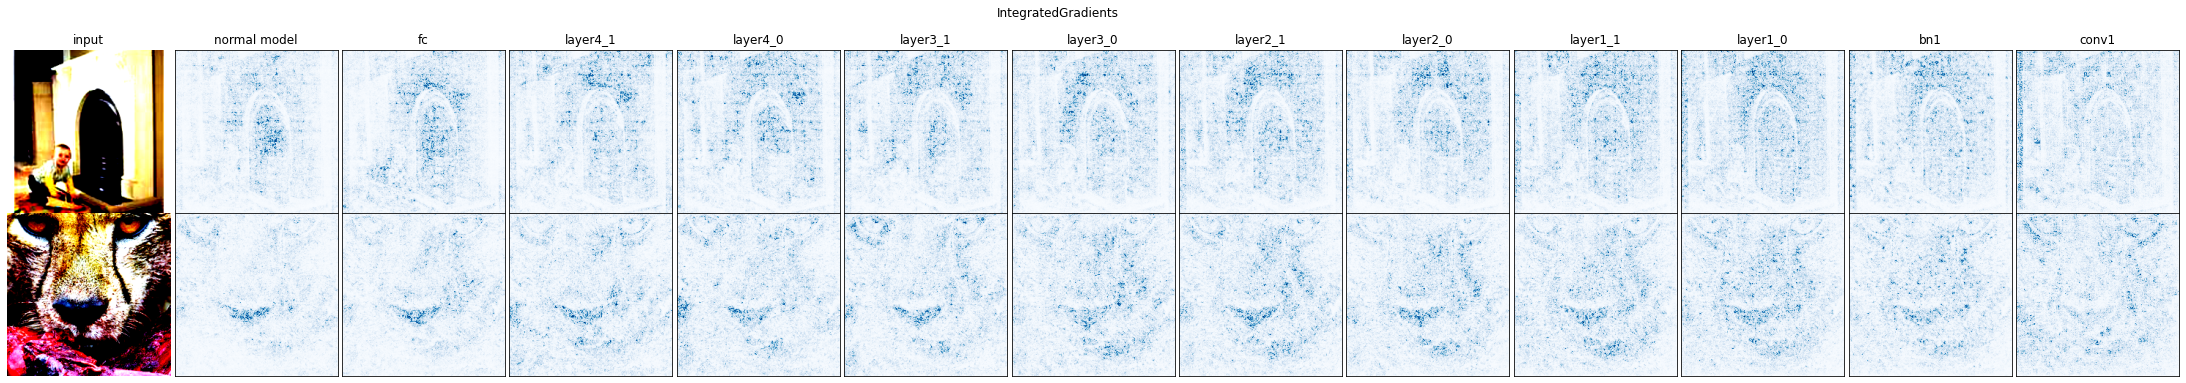

In [5]:
# visualize integrated gradients
fig, _ = util.visualize_cascading_randomization(resnet, module_paths, test_loader, IntegratedGradients)
fig.show()

In [6]:
# visualize integrated gradients
fig, _ = util.visualize_cascading_randomization_single_example(resnet, module_paths, (img, label), Saliency)
fig.show()

NameError: name 'img' is not defined

In [ ]:
resnet

In [ ]:
for k in resnet.modules():
    if isinstance(k, torch.nn.modules.container.Sequential):
        print(k.children())
        print(k.downsample)
#         for l in k.modules():
#             print(l)
        
print(type(resnet.layer4[0].conv1))